In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(handle="nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

path_energy = path + "/energy_dataset.csv"
path_weather = path + "/weather_features.csv"

# Load the datasets
import pandas as pd

energy_df = pd.read_csv(path_energy)
# Taking the dataset that was cleaned in the baseline notebook for weather
weather_df = pd.read_csv('./weather_features_binary_cleaned.csv')

c:\Users\rami0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\rami0\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1
Path to dataset files: C:\Users\rami0\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1


In [2]:
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,...,has_rain,has_drizzle,has_mist,has_fog,has_thunderstorm,has_snow,has_clouds,has_clear,has_haze,has_dust
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,False,False,False,False,False,False,False,True,False,False
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,False,False,False,False,False,False,False,True,False,False
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False
3,2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False
4,2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False


# LE3: Transformieren - Aggregation der Wetterdaten

## Huber/M-Estimator Mean Aggregation

Der Huber-Schätzer ist eine robuste Methode zur Berechnung des Mittelwerts, die weniger empfindlich gegenüber Ausreißern ist als der arithmetische Mittelwert. Er kombiniert die Effizienz des Mittelwerts mit der Robustheit des Medians.

Die Huber-Verlustfunktion ist definiert als:
$$
L_\delta(a) = \begin{cases}
\frac{1}{2}a^2 & \text{für } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{sonst}
\end{cases}
$$

Dabei ist $\delta$ der Tuning-Parameter, der bestimmt, ab welchem Punkt die Funktion von quadratisch auf linear wechselt.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from scipy import stats

def huber_mean(data, delta=1.35):
    """
    Calculate the Huber M-estimator mean for a given dataset.
    Uses iteratively reweighted least squares to compute a robust mean.
    
    Parameters:
    -----------
    data : array-like
        The data to compute the robust mean for
    delta : float
        The Huber tuning parameter (default 1.35 for ~95% efficiency)
    
    Returns:
    --------
    float : The Huber M-estimator mean
    """
    data = np.array(data).flatten()
    data = data[~np.isnan(data)]  # Remove NaN values
    
    if len(data) == 0:
        return np.nan
    if len(data) == 1:
        return data[0]
    
    # Use scipy's Huber M-estimator
    try:
        loc, scale = stats.mstats.huber_mean_scale(data, k=delta)
        return loc
    except:
        # Fallback to median if Huber fails
        return np.median(data)

def circular_mean(angles_deg):
    """
    Calculate the circular (angular) mean for wind direction data.
    Wind direction is measured in degrees (0-360), so we need to handle
    the circular nature of the data (e.g., average of 350° and 10° should be 0°, not 180°).
    
    Parameters:
    -----------
    angles_deg : array-like
        Wind direction angles in degrees (0-360)
    
    Returns:
    --------
    float : The circular mean in degrees (0-360)
    """
    angles_deg = np.array(angles_deg).flatten()
    angles_deg = angles_deg[~np.isnan(angles_deg)]
    
    if len(angles_deg) == 0:
        return np.nan
    
    # Convert to radians
    angles_rad = np.deg2rad(angles_deg)
    
    # Calculate mean of sin and cos components
    mean_sin = np.mean(np.sin(angles_rad))
    mean_cos = np.mean(np.cos(angles_rad))
    
    # Calculate circular mean using atan2
    mean_angle_rad = np.arctan2(mean_sin, mean_cos)
    mean_angle_deg = np.rad2deg(mean_angle_rad)
    
    # Ensure result is in [0, 360) range
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    
    return mean_angle_deg

# Test the functions
test_data = [1, 2, 3, 4, 5, 100]  # With outlier
print(f"Test data: {test_data}")
print(f"Arithmetic mean: {np.mean(test_data):.2f}")
print(f"Median: {np.median(test_data):.2f}")
print(f"Huber mean: {huber_mean(test_data):.2f}")

# Test circular mean with wind directions
test_wind = [350, 10, 5, 355]  # Directions around North
print(f"\nWind directions: {test_wind}")
print(f"Arithmetic mean: {np.mean(test_wind):.1f}°")
print(f"Circular mean: {circular_mean(test_wind):.1f}°")
print(f"Huber wind mean: {huber_mean(test_wind):.1f}°")

Test data: [1, 2, 3, 4, 5, 100]
Arithmetic mean: 19.17
Median: 3.50
Huber mean: 3.50

Wind directions: [350, 10, 5, 355]
Arithmetic mean: 180.0°
Circular mean: 360.0°
Huber wind mean: 180.0°


In [5]:
# Compare the dataset wind deg with circular and huber mean.
wind_deg = weather_df['wind_deg'].dropna().values
print(f"\nDataset wind directions (first 10): {wind_deg[:10]}")

print(f"Arithmetic mean: {np.mean(wind_deg):.1f}°")
print(f"Circular mean: {circular_mean(wind_deg):.1f}°")
print(f"Huber wind mean: {huber_mean(wind_deg):.1f}°")    


Dataset wind directions (first 10): [ 62  62  23  23  23 321 321 321 307 307]
Arithmetic mean: 166.7°
Circular mean: 334.0°
Huber wind mean: 178.0°


In [6]:
def aggregate_weather_huber(weather_df, numeric_cols=None, binary_cols=None, circular_cols=None, delta=1.35):
    """
    Aggregate weather data from multiple cities into a single row per timestamp
    using Huber M-estimator mean for robustness against outliers.
    
    Parameters:
    -----------
    weather_df : pd.DataFrame
        Weather dataframe with datetime index and 'city_name' column
    numeric_cols : list, optional
        List of numeric columns to aggregate with Huber mean.
    binary_cols : list, optional
        List of binary columns to aggregate with max (OR logic).
    circular_cols : list, optional
        List of circular columns (e.g., wind_deg) to aggregate with circular mean.
    delta : float
        Huber tuning parameter
    
    Returns:
    --------
    pd.DataFrame : Aggregated weather data with one row per timestamp
    """
    aggregated_parts = []
    
    # Aggregate numeric columns with Huber mean
    if numeric_cols:
        available_numeric = [col for col in numeric_cols if col in weather_df.columns]
        if available_numeric:
            numeric_agg = weather_df.groupby(weather_df.index)[available_numeric].agg(
                lambda x: huber_mean(x.values, delta=delta)
            )
            aggregated_parts.append(numeric_agg)
    
    # Aggregate binary columns with max (OR logic)
    if binary_cols:
        available_binary = [col for col in binary_cols if col in weather_df.columns]
        if available_binary:
            binary_agg = weather_df.groupby(weather_df.index)[available_binary].max()
            aggregated_parts.append(binary_agg)
    
    # Aggregate circular columns with circular mean
    if circular_cols:
        available_circular = [col for col in circular_cols if col in weather_df.columns]
        if available_circular:
            circular_agg = weather_df.groupby(weather_df.index)[available_circular].agg(
                lambda x: circular_mean(x.values)
            )
            aggregated_parts.append(circular_agg)
    
    # Combine all parts
    if aggregated_parts:
        return pd.concat(aggregated_parts, axis=1)
    else:
        # Fallback: aggregate all numeric columns
        numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
        return weather_df.groupby(weather_df.index)[numeric_cols].agg(
            lambda x: huber_mean(x.values, delta=delta)
        )

# Define column categories
weather_numeric_cols = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 
                        'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
weather_binary_cols = ['has_rain', 'has_drizzle', 'has_mist', 'has_fog',
                       'has_thunderstorm', 'has_snow', 'has_clouds', 
                       'has_clear', 'has_haze', 'has_dust']
weather_circular_cols = ['wind_deg']

# Filter to only existing columns
weather_numeric_cols = [col for col in weather_numeric_cols if col in weather_df.columns]
weather_binary_cols = [col for col in weather_binary_cols if col in weather_df.columns]
weather_circular_cols = [col for col in weather_circular_cols if col in weather_df.columns]

print(f"Numeric columns: {weather_numeric_cols}")
print(f"Binary columns: {weather_binary_cols}")
print(f"Circular columns: {weather_circular_cols}")

# Apply Huber aggregation
weather_aggregated = aggregate_weather_huber(
    weather_df, 
    numeric_cols=weather_numeric_cols,
    binary_cols=weather_binary_cols,
    circular_cols=weather_circular_cols
)
print(f"\nOriginal weather data shape: {weather_df.shape}")
print(f"Aggregated weather data shape: {weather_aggregated.shape}")
weather_aggregated.head()

Numeric columns: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
Binary columns: ['has_rain', 'has_drizzle', 'has_mist', 'has_fog', 'has_thunderstorm', 'has_snow', 'has_clouds', 'has_clear', 'has_haze', 'has_dust']
Circular columns: ['wind_deg']

Original weather data shape: (175320, 28)
Aggregated weather data shape: (175320, 21)

Original weather data shape: (175320, 28)
Aggregated weather data shape: (175320, 21)


,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,clouds_all,...,has_drizzle,has_mist,has_fog,has_thunderstorm,has_snow,has_clouds,has_clear,has_haze,has_dust,wind_deg
0,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,62.0
1,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,62.0
2,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0
3,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0
4,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0


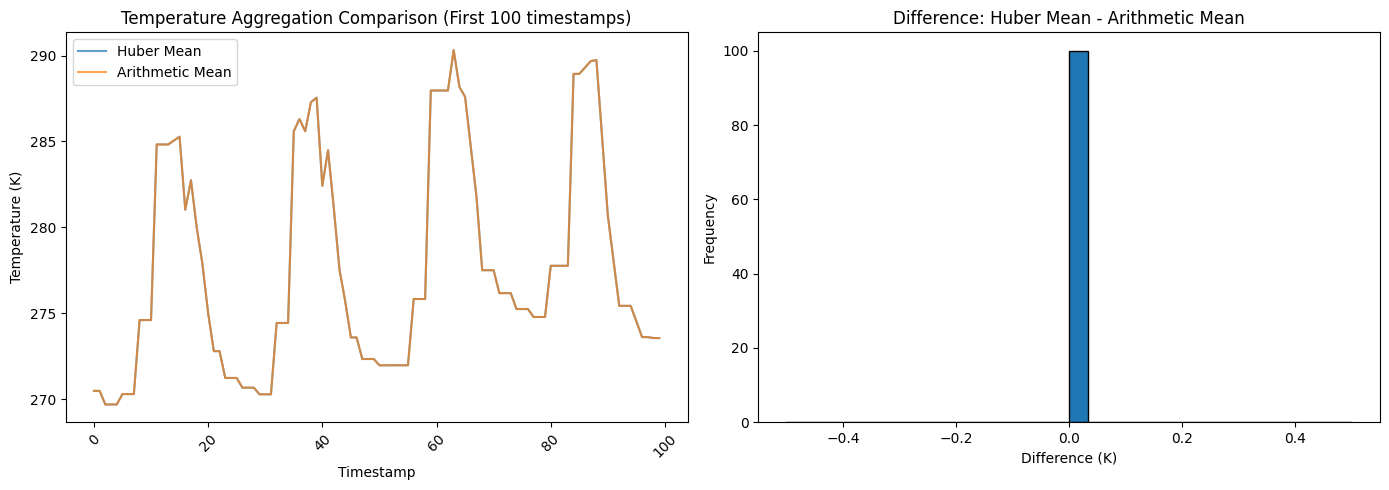

Mean absolute difference: 0.0000 K
Max absolute difference: 0.0000 K


In [7]:
# Compare Huber aggregation with simple mean (baseline)
def aggregate_weather_mean(weather_df, numeric_cols=None):
    """Baseline: Simple arithmetic mean aggregation"""
    if numeric_cols is None:
        numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
    return weather_df.groupby(weather_df.index)[numeric_cols].mean()

weather_mean = aggregate_weather_mean(weather_df, numeric_cols=weather_numeric_cols)

# Compare the two aggregation methods
comparison_df = pd.DataFrame({
    'Huber Mean': weather_aggregated['temp'].head(100),
    'Arithmetic Mean': weather_mean['temp'].head(100)
})

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(comparison_df.index, comparison_df['Huber Mean'], label='Huber Mean', alpha=0.7)
plt.plot(comparison_df.index, comparison_df['Arithmetic Mean'], label='Arithmetic Mean', alpha=0.7)
plt.title('Temperature Aggregation Comparison (First 100 timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
diff = comparison_df['Huber Mean'] - comparison_df['Arithmetic Mean']
plt.hist(diff.dropna(), bins=30, edgecolor='black')
plt.title('Difference: Huber Mean - Arithmetic Mean')
plt.xlabel('Difference (K)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Mean absolute difference: {np.abs(diff).mean():.4f} K")
print(f"Max absolute difference: {np.abs(diff).max():.4f} K")

## Feature Engineering: Lag Features für Zeitreihenanalyse

Für Zeitreihenprognosen erstellen wir Lag-Features (verzögerte Werte) basierend auf verschiedenen Zeitfenstern.

In [8]:
def create_lag_features(df, columns, lags):
    """
    Create lag features for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with datetime index
    columns : list
        Columns to create lag features for
    lags : list of int
        Lag periods in hours (e.g., [1, 24, 168] for 1 hour, 1 day, 1 week)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with added lag features
    """
    df_lagged = df.copy()
    
    for col in columns:
        for lag in lags:
            df_lagged[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    return df_lagged

def create_rolling_features(df, columns, windows):
    """
    Create rolling aggregate features (min, max, mean) for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with datetime index
    columns : list
        Columns to create rolling features for
    windows : list of int
        Rolling window sizes in hours
    
    Returns:
    --------
    pd.DataFrame : DataFrame with added rolling features
    """
    df_rolled = df.copy()
    
    for col in columns:
        for window in windows:
            df_rolled[f'{col}_rolling_min_{window}h'] = df[col].rolling(window=window).min()
            df_rolled[f'{col}_rolling_max_{window}h'] = df[col].rolling(window=window).max()
            df_rolled[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
    
    return df_rolled

# Apply feature engineering to aggregated weather data
lag_periods = [1, 24, 168]  # 1 hour, 1 day, 1 week
rolling_windows = [24, 168]  # 1 day, 1 week

key_weather_cols = ['temp', 'humidity', 'pressure', 'wind_speed']
key_weather_cols = [col for col in key_weather_cols if col in weather_aggregated.columns]

# Create lag features
weather_features = create_lag_features(weather_aggregated, key_weather_cols, lag_periods)

# Create rolling features
weather_features = create_rolling_features(weather_features, ['temp'], rolling_windows)

print(f"Weather features shape after engineering: {weather_features.shape}")
print(f"\nNew columns added:")
new_cols = [col for col in weather_features.columns if col not in weather_aggregated.columns]
print(new_cols)

Weather features shape after engineering: (175320, 39)

New columns added:
['temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'humidity_lag_1h', 'humidity_lag_24h', 'humidity_lag_168h', 'pressure_lag_1h', 'pressure_lag_24h', 'pressure_lag_168h', 'wind_speed_lag_1h', 'wind_speed_lag_24h', 'wind_speed_lag_168h', 'temp_rolling_min_24h', 'temp_rolling_max_24h', 'temp_rolling_mean_24h', 'temp_rolling_min_168h', 'temp_rolling_max_168h', 'temp_rolling_mean_168h']


# LE4: Verknüpfen - Joining Weather and Energy Data

Die Wetter- und Energiedaten werden über den Zeitstempel (Index) verknüpft. Da beide Datensätze stündliche Daten haben, können wir einen direkten Join durchführen.

In [ ]:
def join_energy_weather(energy_df, weather_df, how='inner'):
    """
    Join energy and weather dataframes on their datetime index.
    
    Parameters:
    -----------
    energy_df : pd.DataFrame
        Energy consumption dataframe with datetime index
    weather_df : pd.DataFrame
        Aggregated weather dataframe with datetime index
    how : str
        Join type ('inner', 'left', 'right', 'outer')
    
    Returns:
    --------
    pd.DataFrame : Combined dataframe
    """
    # Ensure both indices are datetime
    energy_df.index = pd.to_datetime(energy_df.index)
    weather_df.index = pd.to_datetime(weather_df.index)
    
    # Join on index
    combined_df = energy_df.join(weather_df, how=how, lsuffix='_energy', rsuffix='_weather')
    
    return combined_df

# Join the datasets
combined_df = join_energy_weather(energy_df, weather_features, how='inner')

print(f"Energy data shape: {energy_df.shape}")
print(f"Weather features shape: {weather_features.shape}")
print(f"Combined data shape: {combined_df.shape}")
print(f"\nDate range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"\nColumns in combined dataset:")
print(combined_df.columns.tolist())

Energy data shape: (35064, 29)
Weather features shape: (175320, 39)
Combined data shape: (35064, 68)

Date range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000035063

Columns in combined dataset:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'pric

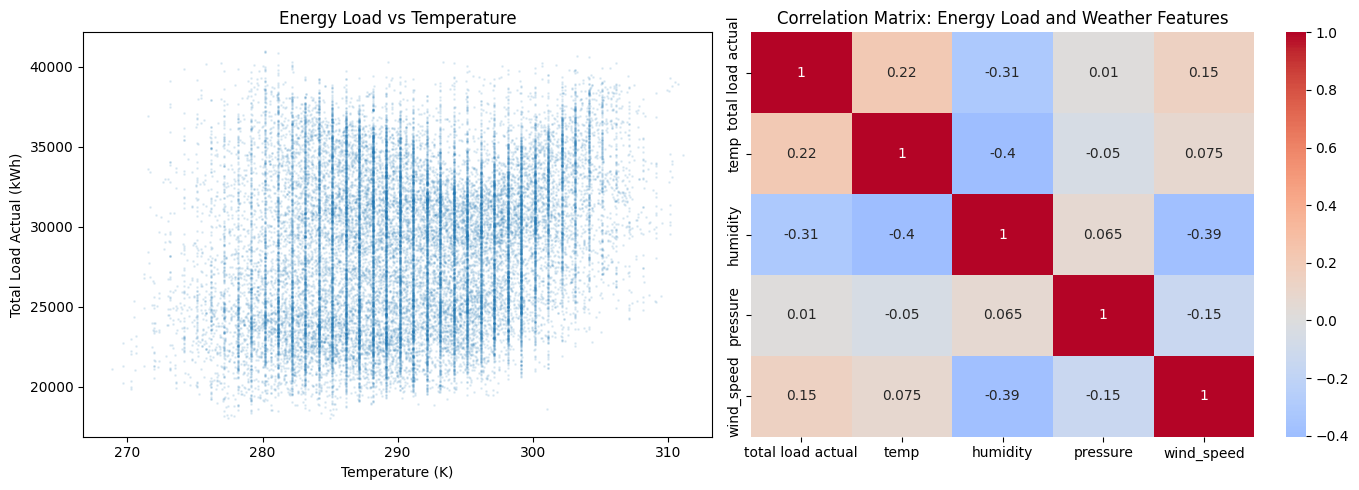


Correlation with Total Load Actual:
total load actual    1.000000
temp                 0.221018
wind_speed           0.147881
pressure             0.010411
humidity            -0.314560
Name: total load actual, dtype: float64


In [10]:
# Visualize the relationship between temperature and energy load
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(combined_df['temp'], combined_df['total load actual'], alpha=0.1, s=1)
plt.xlabel('Temperature (K)')
plt.ylabel('Total Load Actual (kWh)')
plt.title('Energy Load vs Temperature')

plt.subplot(1, 2, 2)
# Calculate correlation
correlation = combined_df[['total load actual', 'temp', 'humidity', 'pressure', 'wind_speed']].corr()
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Energy Load and Weather Features')

plt.tight_layout()
plt.show()

print("\nCorrelation with Total Load Actual:")
print(correlation['total load actual'].sort_values(ascending=False))

---

## Nächste Schritte

Die vollständige **DataWranglingPipeline** Klasse und alle Hilfsfunktionen wurden in das Modul `data_pipeline.py` ausgelagert. 

Die Pipeline kann wie folgt verwendet werden:

```python
from data_pipeline import DataWranglingPipeline

pipeline = DataWranglingPipeline(aggregation_method='huber')
result = pipeline.run(path_energy, path_weather)
```

Siehe `LE5_Datenpipelines_Trimmed_Mean.ipynb` für die vollständige Pipeline-Demonstration mit verschiedenen Aggregationsmethoden.